In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
analytical_retardation_type = "langmuir"

In [3]:
def is_valid_directory(sim_dir, verbose=False):
    group_name_file = sim_dir.parent / "group_name.txt"
    if not group_name_file.exists():
        if verbose:
            print(f"{group_name_file} does not exist")
        return False, None

    pred_ret_dir = sim_dir / "predicted_retardations"
    if not pred_ret_dir.exists() or not list(pred_ret_dir.iterdir()):
        if verbose:
            print(f"{pred_ret_dir} does not exist or is empty")
        return False, None

    try:
        c_train = np.load(sim_dir / "c_train.npy")
        c_predictions = np.load(sim_dir / "c_predictions.npy")
    except FileNotFoundError:
        if verbose:
            print(f"{sim_dir} does not contain c_train.npy or c_predictions.npy")
        return False, None
    if np.mean((c_train - c_predictions) ** 2) > 1e-4:
        if verbose:
            print(f"{sim_dir} has too large MSE for c")
        return False, None

    all_ret_file_paths = sorted(
        (sim_dir / "predicted_retardations").glob("retPred_*.npy"),
        key=lambda x: int(x.stem.split("_")[-1]),
    )
    epoch = int(all_ret_file_paths[-1].stem.split("_")[-1])
    if epoch < 100:
        if verbose:
            print(f"{sim_dir} has too few epochs")
        return False, None
    last_pred_ret = np.load(all_ret_file_paths[-1])
    if (
        np.isnan(last_pred_ret).any()
        or np.isinf(last_pred_ret).any()
        # or np.any((last_pred_ret < 3) | (last_pred_ret > 20))
    ):
        if verbose:
            print(f"{sim_dir}'s last predicted retardation is invalid")
        return False, None

    # is d^2fdx^2 almost zero?
    dx = 1 / 100
    dfdx = np.diff(last_pred_ret, axis=0) / dx
    dfdx2 = np.diff(dfdx, axis=0) / dx
    if np.all(np.abs(dfdx2) < 10):
        if verbose:
            print(f"{sim_dir}'s last predicted retardation is almost a straight line")
        return False, None

    return True, all_ret_file_paths[-1]


def collect_valid_simulation_dirs(root_dir, verbose=False):
    valid_dirs = []
    for ret_dir in root_dir.rglob("predicted_retardations"):
        sim_dir = ret_dir.parent
        is_dir_valid, learned_ret_file_path = is_valid_directory(
            sim_dir, verbose=verbose
        )
        if is_dir_valid:
            group_name = (sim_dir.parent / "group_name.txt").read_text().strip()
            valid_dirs.append((sim_dir, group_name, learned_ret_file_path))
    return valid_dirs


def compute_mse(a, b):
    return np.mean((a - b) ** 2)

In [4]:
# A) Collect all valid simulation directories
# TODO: Why did so few "Noisy C" simulations converge?
# TODO: Put c_train.npy and c_predictions.npy in all "C Loss Mask" simulations
root_dir = Path("../data_out")
valid_sim_dirs = collect_valid_simulation_dirs(root_dir, verbose=False)

sim_data = []
for sim_dir, group_name, learned_ret_file_path in valid_sim_dirs:
    sim_data.append(
        {
            "sim_dir": sim_dir,
            "group_name": group_name,
            "sim_label": f"{group_name}_{sim_dir.name}",
            "learned_ret_file_path": learned_ret_file_path,
        }
    )

sim_df = pd.DataFrame(sim_data)
print(len(sim_df))
sim_df.head()

34


,sim_dir,group_name,sim_label,learned_ret_file_path
0,../data_out/langmuir/finn_running_intervals_st...,Running Interval,Running Interval_c_5,../data_out/langmuir/finn_running_intervals_st...
1,../data_out/langmuir/finn_running_intervals_st...,Running Interval,Running Interval_c_2,../data_out/langmuir/finn_running_intervals_st...
2,../data_out/langmuir/finn_running_intervals_st...,Running Interval,Running Interval_c_3,../data_out/langmuir/finn_running_intervals_st...
3,../data_out/langmuir/finn_running_intervals_st...,Running Interval,Running Interval_c_4,../data_out/langmuir/finn_running_intervals_st...
4,../data_out/langmuir/finn_running_intervals_st...,Running Interval,Running Interval_c_11,../data_out/langmuir/finn_running_intervals_st...


In [5]:
# B) Compute MSE of c and ret for each simulation directory
mse_data = []
for index, row in sim_df.iterrows():
    sim_dir = row["sim_dir"]
    c_train = np.load(sim_dir / "c_train.npy")
    c_predictions = np.load(sim_dir / "c_predictions.npy")
    # u_ret = np.load(sim_dir / "u_ret.npy")
    last_pred_ret = np.load(sim_df.iloc[index]["learned_ret_file_path"])
    analytical_ret = np.load(sim_dir / f"retardation_{analytical_retardation_type}.npy")

    mse_c = compute_mse(c_train, c_predictions)
    mse_ret = compute_mse(analytical_ret, last_pred_ret)

    mse_data.append({"sim_label": row["sim_label"], "mse_c": mse_c, "mse_ret": mse_ret})

mse_df = pd.DataFrame(mse_data)
mse_df.head()

,sim_label,mse_c,mse_ret
0,Running Interval_c_5,3.072960e-09,0.000578
1,Running Interval_c_2,5.356462e-10,0.000019
2,Running Interval_c_3,1.841371e-09,0.000140
3,Running Interval_c_4,1.977043e-10,0.000014
4,Running Interval_c_11,2.041995e-09,0.013178


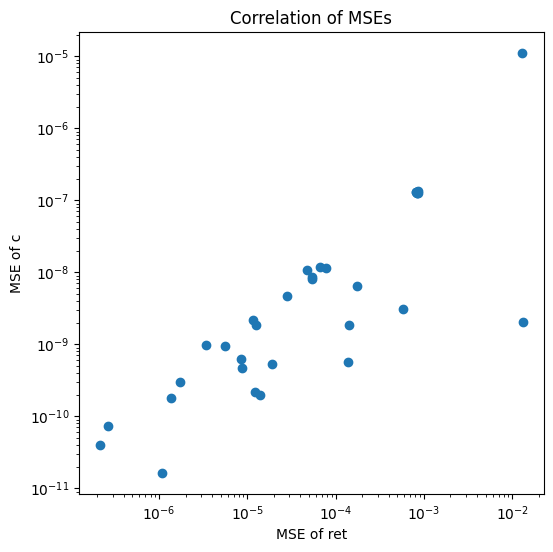

In [6]:
# Plot correlation of MSEs
plt.figure(figsize=(6, 6))
plt.scatter(mse_df["mse_ret"], mse_df["mse_c"])
plt.xscale("log")
plt.yscale("log")
plt.title("Correlation of MSEs")
plt.xlabel("MSE of ret")
plt.ylabel("MSE of c")
plt.show()

In [7]:
# C) Plot final retardations of each simulation directory
ret_df = sim_df.copy()
ret_df["ret"] = sim_df["learned_ret_file_path"].apply(lambda p: np.load(p).ravel())
ret_df = ret_df.explode("ret").reset_index(drop=True)
ret_df["u"] = np.tile(np.arange(0, 100), len(sim_df))
ret_df["ret"] = ret_df["ret"].astype(np.float64)

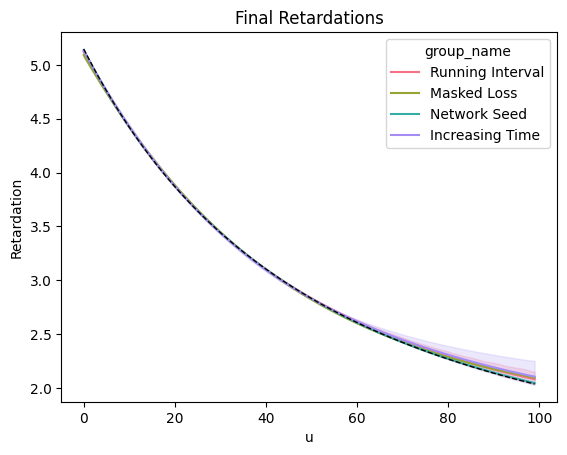

In [8]:
sns.lineplot(
    data=ret_df,
    x="u",
    y="ret",
    hue="group_name",
    # style="group_name",
    # markers=True,
    # dashes=False,
    # legend="brief",
    palette=sns.color_palette("husl", len(sim_df["group_name"].unique())),
)

analytical_ret = np.load(sim_df.iloc[0]["sim_dir"] / f"retardation_{analytical_retardation_type}.npy")
plt.plot(
    analytical_ret,
    label="Analytical Retardation",
    linewidth=1,
    linestyle="--",
    color="black",
    zorder=2,
)
if analytical_retardation_type == "freundlich":
    plt.ylim(3, 5.5)

plt.title("Final Retardations")
plt.xlabel("u")
plt.ylabel("Retardation")
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

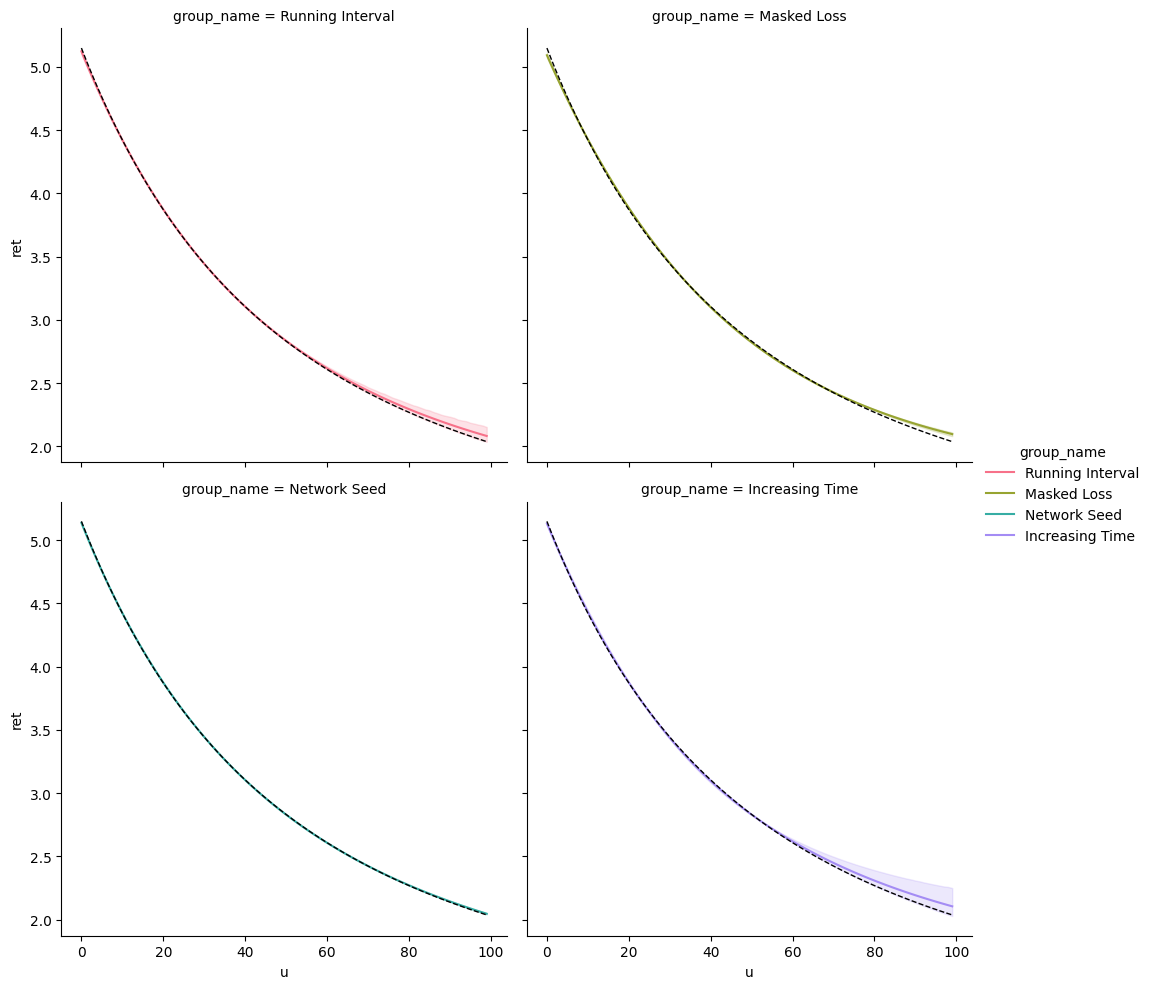

In [16]:
g = sns.relplot(
    data=ret_df,
    kind="line",
    x="u",
    y="ret",
    hue="group_name",
    col="group_name",
    col_wrap=2,
    # style="group_name",
    # markers=True,
    # dashes=False,
    # legend="brief",
    palette=sns.color_palette("husl", len(sim_df["group_name"].unique())),
)

for ax in g.axes.flatten():
    ax.plot(
        analytical_ret,
        label="Analytical Retardation",
        linewidth=1,
        linestyle="--",
        color="black",
        zorder=2,
    )
    if analytical_retardation_type == "freundlich":
        plt.ylim(3, 5.5)

plt.show()

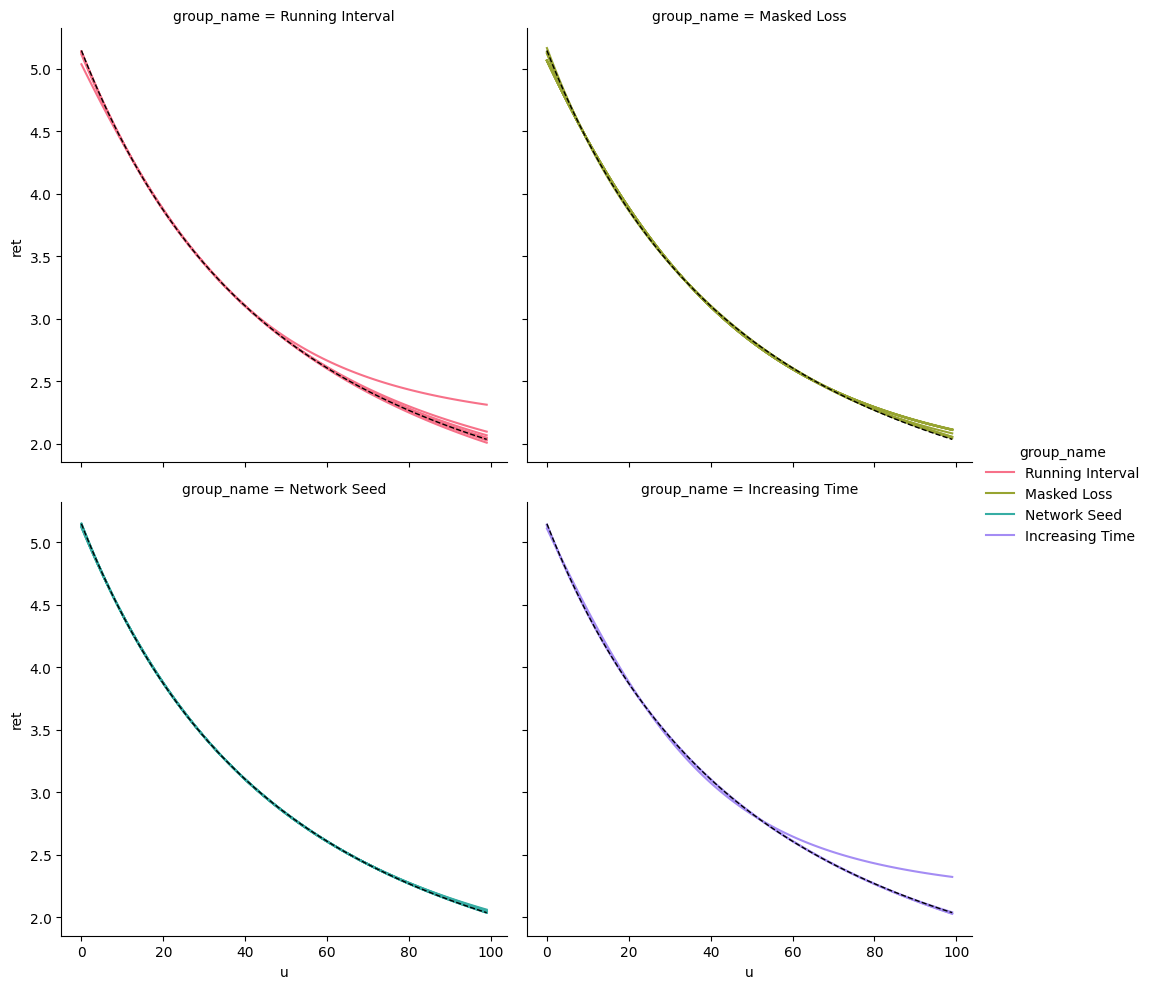

In [17]:
g = sns.relplot(
    data=ret_df,
    kind="line",
    x="u",
    y="ret",
    hue="group_name",
    col="group_name",
    col_wrap=2,
    units="sim_label",
    estimator=None,
    # style="group_name",
    # markers=True,
    # dashes=False,
    # legend="brief",
    palette=sns.color_palette("husl", len(sim_df["group_name"].unique())),
)

for ax in g.axes.flatten():
    ax.plot(
        analytical_ret,
        label="Analytical Retardation",
        linewidth=1,
        linestyle="--",
        color="black",
        zorder=2,
    )
    if analytical_retardation_type == "freundlich":
        plt.ylim(3, 5.5)

plt.show()

In [11]:
# D) Compute enclosing (upper and lower) curves for each group
grouped_ret = ret_df.groupby("group_name")

enclosing_curves = []
for group_name, group in grouped_ret:
    group_ret = group.pivot(index="u", columns="sim_label", values="ret").values
    lower_curve = np.min(group_ret, axis=1)
    upper_curve = np.max(group_ret, axis=1)
    enclosing_curves.append(
        {
            "group_name": group_name,
            "lower_curve": lower_curve.astype(
                float
            ),  # Ensure the curves are float type
            "upper_curve": upper_curve.astype(float),
        }
    )

enclosing_df = pd.DataFrame(enclosing_curves)
enclosing_df.head()

,group_name,lower_curve,upper_curve
0,Increasing Time,"[5.109652996063232, 5.041159152984619, 4.97317...","[5.141552448272705, 5.0608320236206055, 4.9822..."
1,Masked Loss,"[5.065720558166504, 4.997257709503174, 4.92979...","[5.167303562164307, 5.081233501434326, 4.99791..."
2,Network Seed,"[5.119466304779053, 5.042616844177246, 4.96749...","[5.149724960327148, 5.0667877197265625, 4.9863..."
3,Running Interval,"[5.037750244140625, 4.971907615661621, 4.90673...","[5.141021728515625, 5.060344696044922, 4.98178..."


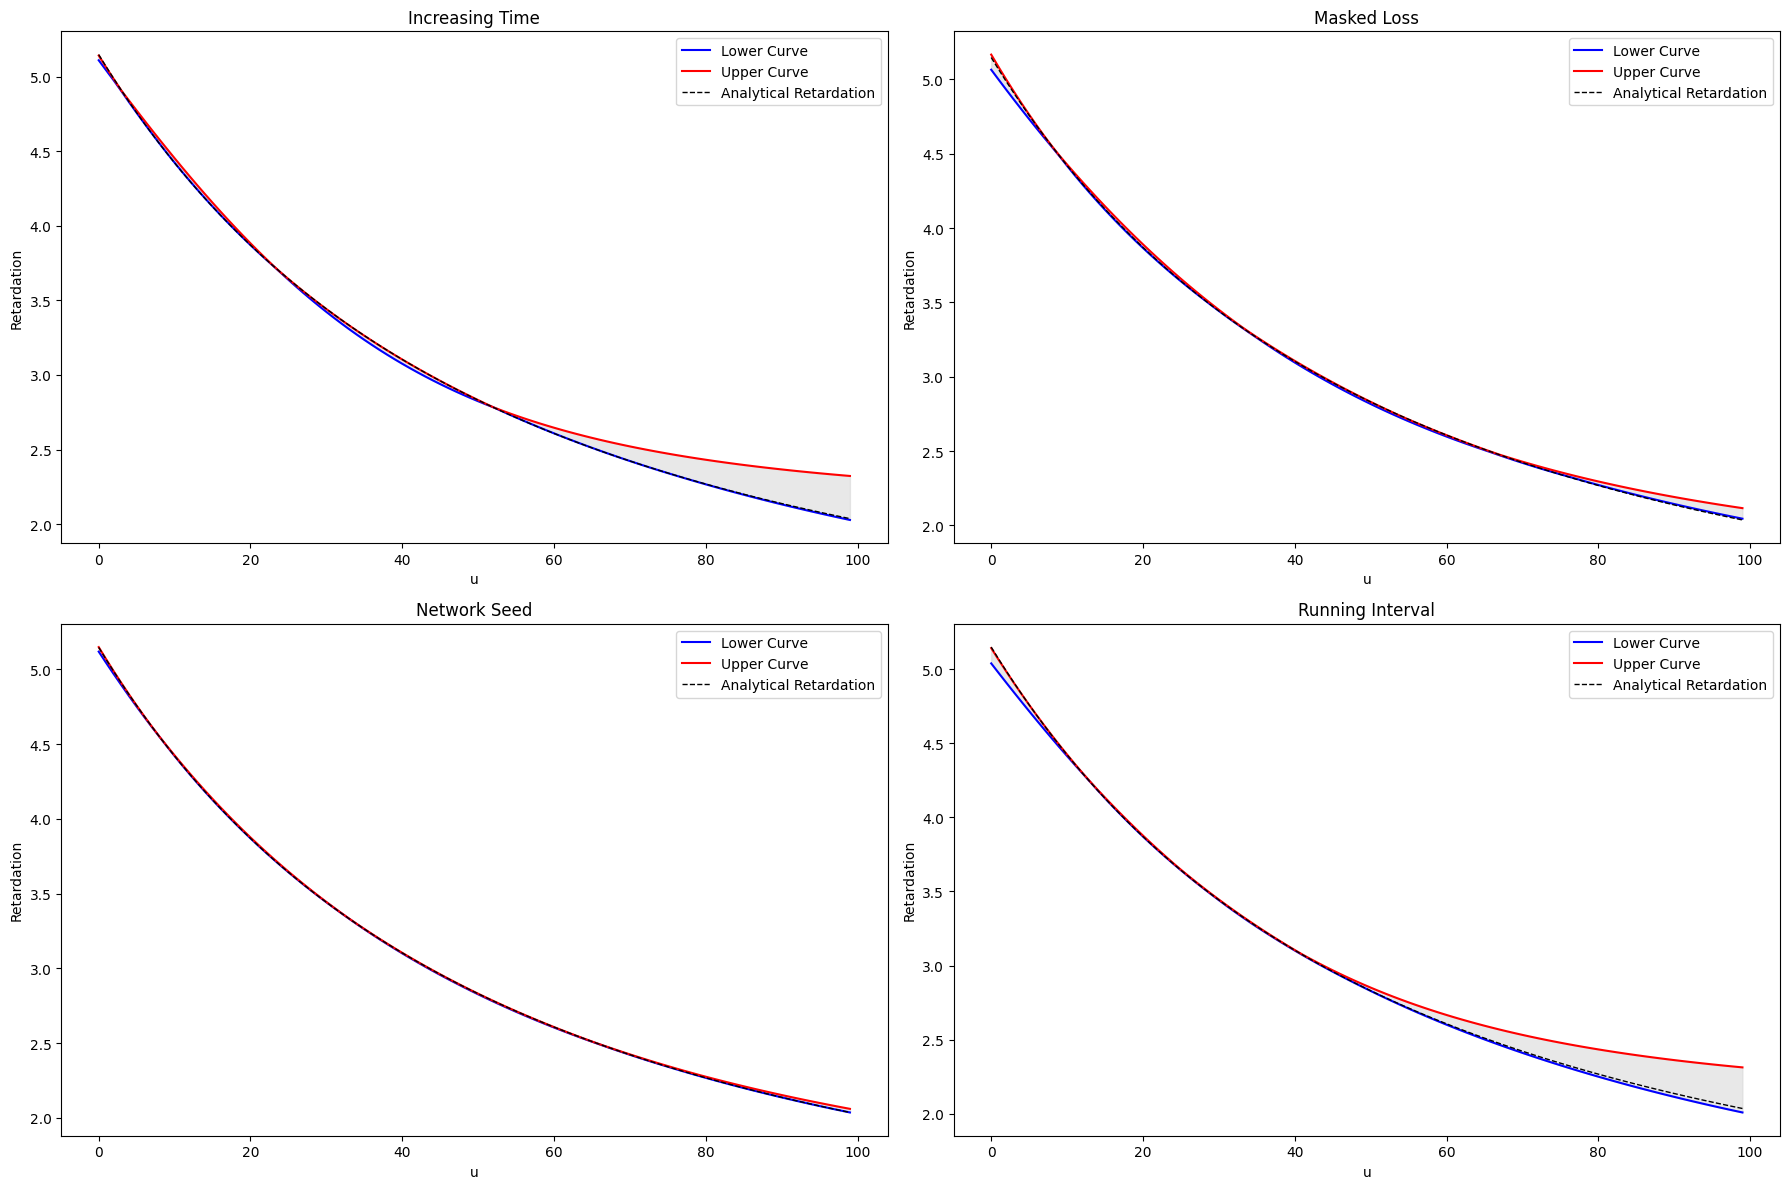

In [18]:
# E) Plot enclosing curves for each group pair in a single figure with NxM axes
num_groups = len(enclosing_df)
ncols = 2  # Number of columns in the plot grid
nrows = (num_groups + ncols - 1) // ncols  # Number of rows in the plot grid

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows))
axes = axes.flatten()

for i, (group_name, lower_curve, upper_curve) in enumerate(
    zip(
        enclosing_df["group_name"],
        enclosing_df["lower_curve"],
        enclosing_df["upper_curve"],
    )
):
    lower_curve = np.asarray(lower_curve)  # Ensure it's a numpy array
    upper_curve = np.asarray(upper_curve)  # Ensure it's a numpy array

    ax = axes[i]
    ax.fill_between(
        np.arange(len(lower_curve)),
        lower_curve,
        upper_curve,
        color="lightgray",
        alpha=0.5,
    )
    ax.plot(lower_curve, color="blue", label="Lower Curve")
    ax.plot(upper_curve, color="red", label="Upper Curve")
    ax.plot(
        analytical_ret,
        label="Analytical Retardation",
        linewidth=1,
        linestyle="--",
        color="black",
        zorder=2,
    )
    ax.set_title(group_name)
    if analytical_retardation_type == "freundlich":
        ax.set_ylim(3, 5.5)
    ax.set_xlabel("u")
    ax.set_ylabel("Retardation")
    ax.legend()

plt.tight_layout()
plt.show()


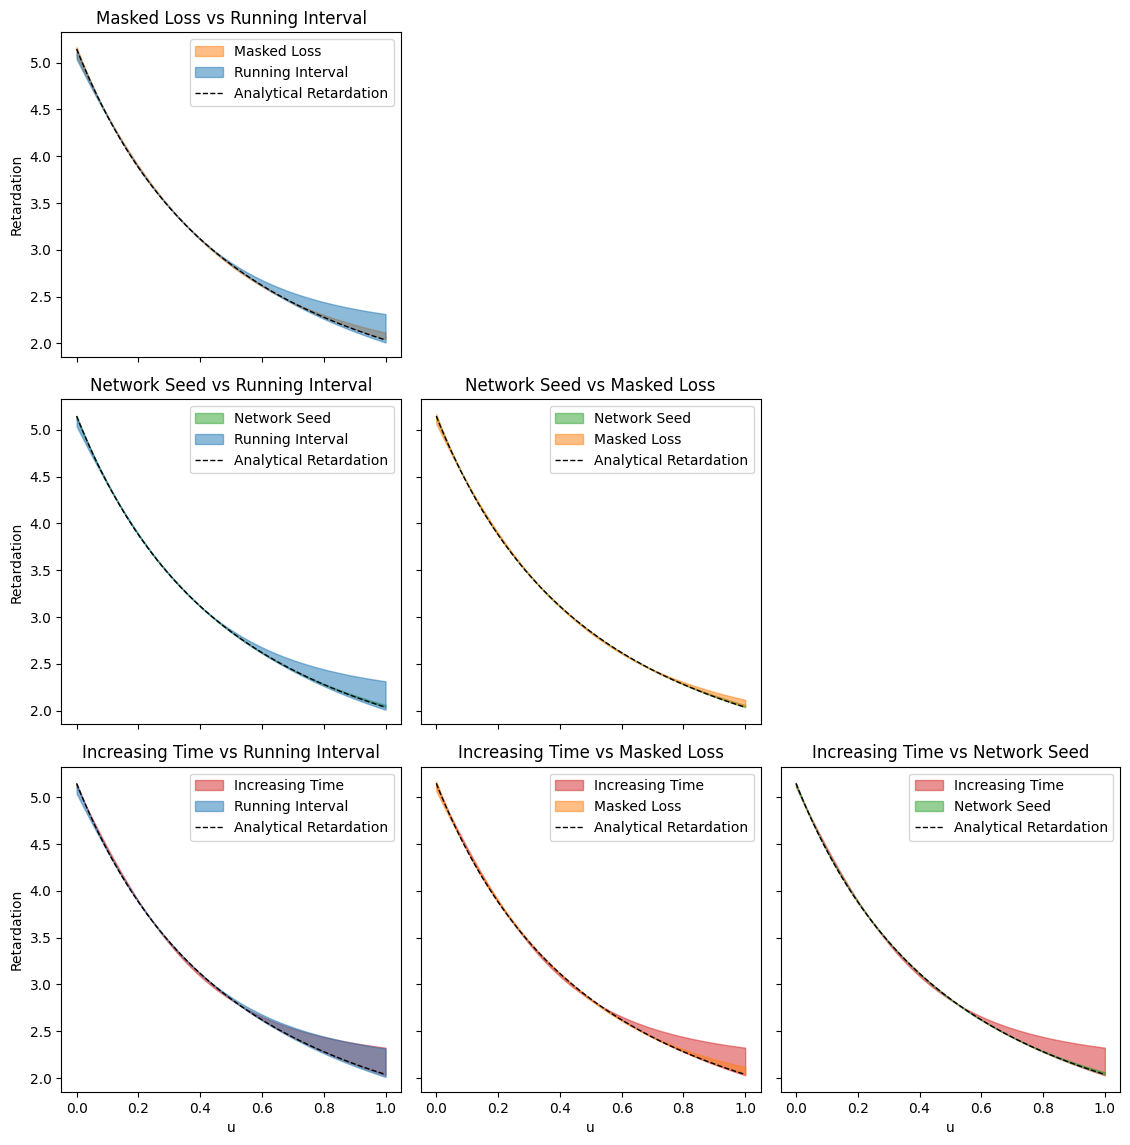

In [13]:
ALPHA_ENVELOPES = 0.5
ALPHA_CURVES = 0.3

# %% Compute and plot enclosing curves
groups = sim_df["group_name"].unique()
group_colors = {group: f"C{i}" for i, group in enumerate(groups)}
num_groups = len(groups)
fig, axes = plt.subplots(
    num_groups, num_groups, figsize=(15, 15), sharex=True, sharey=True
)

for i, group1 in enumerate(groups):
    for j, group2 in enumerate(groups):
        ax = axes[i, j]

        if i <= j:
            fig.delaxes(ax)  # Hide empty axes
            continue

        color1 = group_colors[group1]
        color2 = group_colors[group2]

        u = np.linspace(0, 1, analytical_ret.size)

        # Plot single curves
        # for sim_label in sim_df[sim_df["group_name"] == group1]["sim_label"]:
        #     ret = ret_df[ret_df["sim_label"] == sim_label]["ret"].values
        #     ax.plot(u, ret, color=color1, alpha=ALPHA_CURVES)
        # for sim_label in sim_df[sim_df["group_name"] == group2]["sim_label"]:
        #     ret = ret_df[ret_df["sim_label"] == sim_label]["ret"].values
        #     ax.plot(u, ret, color=color2, alpha=ALPHA_CURVES)

        # Compute and plot enclosing curves
        ret_group1 = np.asarray(
            ret_df[ret_df["group_name"] == group1]["ret"].values.reshape(
                -1, analytical_ret.size
            )
        )
        ret_group2 = np.asarray(
            ret_df[ret_df["group_name"] == group2]["ret"].values.reshape(
                -1, analytical_ret.size
            )
        )
        min_curve1 = np.min(ret_group1, axis=0)
        max_curve1 = np.max(ret_group1, axis=0)
        min_curve2 = np.min(ret_group2, axis=0)
        max_curve2 = np.max(ret_group2, axis=0)

        ax.fill_between(
            x=u,
            y1=min_curve1,
            y2=max_curve1,
            color=color1,
            alpha=ALPHA_ENVELOPES,
            label=group1,
        )
        ax.fill_between(
            x=u,
            y1=min_curve2,
            y2=max_curve2,
            color=color2,
            alpha=ALPHA_ENVELOPES,
            label=group2,
        )

        # Plot enveloping curves
        # ax.plot(u, min_curve1, color=color1, linewidth=2)
        # ax.plot(u, max_curve1, color=color1, linewidth=2)
        # ax.plot(u, min_curve2, color=color2, linewidth=2)
        # ax.plot(u, max_curve2, color=color2, linewidth=2)

        ax.plot(
            u,
            analytical_ret,
            color="black",
            linewidth=1,
            linestyle="--",
            label="Analytical Retardation",
            zorder=2,
        )

        if analytical_retardation_type == "freundlich":
            ax.set_ylim(3, 5.5)
        ax.set_title(f"{group1} vs {group2}")
        if j == 0:
            ax.set_ylabel("Retardation")
        if i == num_groups - 1:
            ax.set_xlabel("u")
        ax.legend()


plt.tight_layout()
plt.show()

# Sample Points between Curves for PI3NN

2651 are between for Running Interval
714 are between for Masked Loss
223 are between for Network Seed
2421 are between for Increasing Time


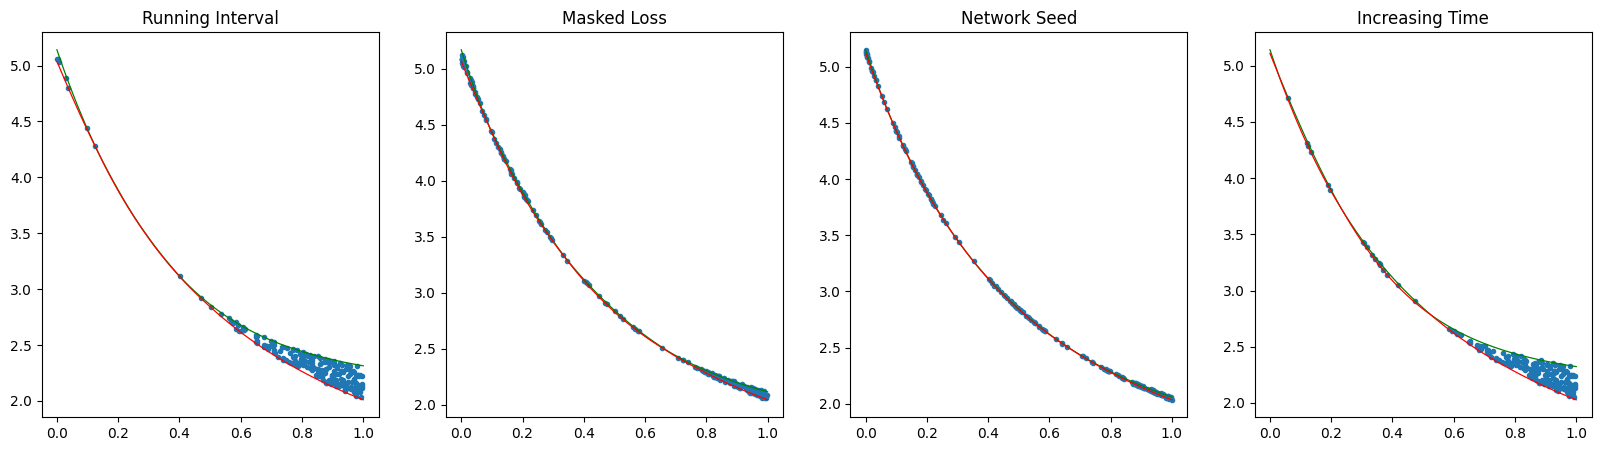

In [14]:
from common import is_below_curve, is_above_curve

fig, axs = plt.subplots(1, len(groups), figsize=(5*len(groups), 5))

group_envelope_points = {}

for i, group1 in enumerate(groups):
    u = np.linspace(0, 1, analytical_ret.size)

    # Compute enclosing curves
    ret_group = np.asarray(
        ret_df[ret_df["group_name"] == group1]["ret"].values.reshape(
            -1, analytical_ret.size
        )
    )
    envelope_curve_up = np.max(ret_group, axis=0)
    envelope_curve_down = np.min(ret_group, axis=0)

    # Sample points
    y_max = envelope_curve_up.max()
    y_min = envelope_curve_down.min()

    rng = np.random.default_rng(2864343564)
    rectangle_points = rng.uniform(low=0, high=1, size=(10**5, 2))
    rectangle_points[:, 1] = rectangle_points[:, 1] * (y_max - y_min) + y_min

    is_below = is_below_curve(u, envelope_curve_up, rectangle_points)
    is_above = is_above_curve(u, envelope_curve_down, rectangle_points)
    is_between = is_below * is_above

    envelope_points = rectangle_points[is_between].copy()
    group_envelope_points[group1] = envelope_points

    # Plot sampled points
    print(f"{len(envelope_points)} are between for {group1}")
    u = np.linspace(0,1,len(envelope_curve_up))
    axs[i].plot(*envelope_points[:200].T, ".")
    axs[i].plot(u, envelope_curve_up, "g-", lw=0.9)
    axs[i].plot(u, envelope_curve_down, "r-", lw=0.9)
    axs[i].set_title(group1)

plt.show()

In [15]:
# Save envelope points
for group, envelope_points in group_envelope_points.items():
    assert len(envelope_points) >= 500
    pinn_base_path = Path("../data_out/3pinn").resolve()
    pinn_dir = pinn_base_path / f"{group.replace(' ', '_')}"
    pinn_dir.mkdir(exist_ok=True, parents=True)
    pinn_x_path = pinn_dir / "x.npy"
    pinn_y_path = pinn_dir / "y.npy"

    np.save(pinn_x_path, envelope_points[:500, 0])
    np.save(pinn_y_path, envelope_points[:500, 1])

AssertionError: 